In [ ]:
import tensorflow as tf
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:


data = read_text("esp_pur.txt")
beng_eng = to_lines(data)
beng_eng = array(beng_eng)

In [ ]:
beng_eng = beng_eng[:990,:]

In [ ]:
beng_eng

array([['Come', 'A'],
       ['Señor', 'Acha'],
       ['Señor de respeto', 'Achaati'],
       ...,
       ['Sal', 'Itukua'],
       ['Pus', 'Iuani'],
       ['Madera que sirve para hacer leño', 'Iuikua']], dtype='<U53')

In [ ]:
# Remove punctuation
beng_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in beng_eng[:,0]]
beng_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in beng_eng[:,1]]

beng_eng

array([['Come', 'A'],
       ['Señor', 'Acha'],
       ['Señor de respeto', 'Achaati'],
       ...,
       ['Sal', 'Itukua'],
       ['Pus', 'Iuani'],
       ['Madera que sirve para hacer leño', 'Iuikua']], dtype='<U53')

In [ ]:
# convert text to lowercase
for i in range(len(beng_eng)):
    beng_eng[i,0] = beng_eng[i,0].lower()
    beng_eng[i,1] = beng_eng[i,1].lower()

beng_eng[0,1]

'a'

In [ ]:
# empty lists
eng_l = []
ben_l = []

# populate the lists with sentence lengths
for i in beng_eng[:,0]:
      eng_l.append(len(i.split()))

for i in beng_eng[:,1]:
      ben_l.append(len(i.split()))



In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = tf.keras.preprocessing.text.Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# prepare Español tokenizer
eng_tokenizer = tokenization(beng_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('Tamaño de Vocabulario en Español: %d' % eng_vocab_size)

import json 
with open( 'word_dict1.json' , 'w' ) as file:    
    json.dump( eng_tokenizer.index_word , file )


English Vocabulary Size: 900


In [ ]:
# prepare Purépecha tokenizer
deu_tokenizer = tokenization(beng_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

ben_length = 8
print('Tamaño de Vocabulario en Purépecha: %d' % deu_vocab_size)

import json 
with open( 'word_dict.json' , 'w' ,encoding='utf8') as file:    
    json.dump( deu_tokenizer.index_word , file, ensure_ascii=False )
    

Deutch Vocabulary Size: 986


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(beng_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainY = encode_sequences(deu_tokenizer, ben_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testY = encode_sequences(deu_tokenizer, ben_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(tf.keras.layers.LSTM(units))
      model.add(tf.keras.layers.RepeatVector(out_timesteps))
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
      model.add(tf.keras.layers.Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
# model compilation
model = define_model( eng_vocab_size,deu_vocab_size, eng_length,ben_length, 512)
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            460800    
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 986)            505818    
                                                                 
Total params: 5,165,018
Trainable params: 5,165,018
Non-trainable params: 0
______________________________________________

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_logical_devices('GPU')



Num GPUs Available:  0


In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# train model

filename = 'model_traductor'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=100, batch_size=128, 
          validation_split = 0.1,
          callbacks=[checkpoint], verbose=1)

model.save(filename)


Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 4.6878 - accuracy: 0.7177
Epoch 1: val_loss improved from inf to 1.71965, saving model to model_traductor


6/6 [==============================] - 32s 5s/step - loss: 4.6878 - accuracy: 0.7177 - val_loss: 1.7196 - val_accuracy: 0.8750
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.8750
Epoch 2: val_loss improved from 1.71965 to 1.37317, saving model to model_traductor


6/6 [==============================] - 22s 4s/step - loss: 1.3563 - accuracy: 0.8750 - val_loss: 1.3732 - val_accuracy: 0.8750
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.0311 - accuracy: 0.8750
Epoch 3: val_loss improved from 1.37317 to 1.22241, saving model to model_traductor


6/6 [==============================] - 23s 4s/step - loss: 1.0311 - accuracy: 0.8750 - val_loss: 1.2224 - val_accuracy: 0.8750
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.9092 - accuracy: 0.8750
Epoch 4: val_loss improved from 1.22241 to 1.18765, saving model to model_traductor


6/6 [==============================] - 23s 4s/step - loss: 0.9092 - accuracy: 0.8750 - val_loss: 1.1877 - val_accuracy: 0.8750
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.8576 - accuracy: 0.8750
Epoch 5: val_loss improved from 1.18765 to 1.14977, saving model to model_traductor


6/6 [==============================] - 24s 5s/step - loss: 0.8576 - accuracy: 0.8750 - val_loss: 1.1498 - val_accuracy: 0.8750
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 0.8455 - accuracy: 0.8750
Epoch 6: val_loss did not improve from 1.14977
6/6 [==============================] - 5s 896ms/step - loss: 0.8455 - accuracy: 0.8750 - val_loss: 1.2264 - val_accuracy: 0.8641
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 0.8370 - accuracy: 0.8750
Epoch 7: val_loss did not improve from 1.14977
6/6 [==============================] - 6s 1s/step - loss: 0.8370 - accuracy: 0.8750 - val_loss: 1.2639 - val_accuracy: 0.8641
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.8750
Epoch 8: val_loss did not improve from 1.14977
6/6 [==============================] - 5s 841ms/step - loss: 0.8295 - accuracy: 0.8750 - val_loss: 1.1782 - val_accuracy: 0.8750
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 0.

In [ ]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('nmt_05_12_19_test_beng.tflite', 'wb').write(tfmodel)

5220968

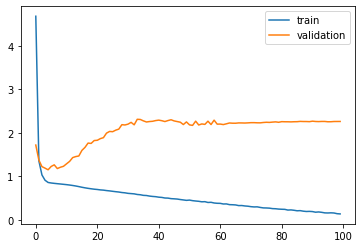

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
#import tensorflow as tf
#tf.keras.backend.set_learning_phase(0)
#Converter = tf.lite.TFLiteConverter.from_keras_model(model)
#Converter.experimental_new_converter = True
#Tflite_model = Converter.convert()
#open("converted_model3G.tflite", "wb").write(Tflite_model)

In [ ]:
#model = tf.keras.models.load_model('model_23_11_19')
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

preds = argmax(model.predict(testX), axis=-1)
preds.shape

7/7 [==============================] - 3s 97ms/step


(198, 8)

In [ ]:
import numpy as np
X_in = [3,189,48,280,0,0,0,0]
t = model.predict(np.reshape(X_in,(1,8)))

np.argmax(t, axis=2)

1/1 [==============================] - 2s 2s/step


array([[732,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
X_in = [3,0,0,0,0,0,0,0]
t = model.predict(np.reshape(X_in,(1,8)))

np.argmax(t, axis=2)

1/1 [==============================] - 0s 39ms/step


array([[751,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
testX.reshape((testX.shape[0],testX.shape[1]))


array([[130, 551,   1, ...,   0,   0,   0],
       [  2,   4,  50, ...,   0,   0,   0],
       [  2,   6,  73, ...,   0,   0,   0],
       ...,
       [ 82,   9,  40, ...,   0,   0,   0],
       [ 17, 207,   0, ...,   0,   0,   0],
       [235,   4, 236, ...,   0,   0,   0]], dtype=int32)

In [ ]:
trainX[0] #INPUT

array([637,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
#deu_tokenizer
#eng_tokenizer
get_word(64,deu_tokenizer)  #INPUT

'ánchikuarhikua'

In [ ]:
get_word(111,eng_tokenizer) #OUTPUT

'punta'

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], deu_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0],'actual2' : test[:,1], 'predicted' : preds_text})

In [ ]:
test[:,1]

array(['amajkuaka', 'enandirhu', 'iretecharhu', 'chénarhini',
       'chukujchukuni', 'chúrikua', 'andanguntani', 'eranguni',
       'chukurhi', 'chikeri', 'itumbecha', 'chunukurhini', 'ekuakuni',
       'achamasï', 'antsitani', 'chéskuni', 'axamu', 'arachani',
       'anhatapu', 'eramukuni', 'ambusï', 'amani', 'éti', 'auajtakuni',
       'ienejkurhani', 'erachijti', 'andani', 'auajtsïkukata', 'euajkuni',
       'ananchani', 'chúrekua', 'chakajkuni', 'eratini', 'chakintsïni',
       'ichamuni', 'erontani', 'ekinha', 'exeraani', 'ásïpiti',
       'ioarhisïrampti', 'iretechani', 'atajtsïkukata', 'chónharhini',
       'itsarhu', 'erandipakua', 'irerakua', 'erani', 'araparha',
       'ekuakuti', 'anhaxurhini', 'chanhasï', 'chikamati', 'iarhini',
       'ikarani', 'auani', 'eraparhani', 'anaratarakuecha', 'ichupio',
       'erajpani', 'apasikua', 'anaricha', 'ichusïkusti', 'irechikua',
       'anani', 'auajtsïuati', 'chopentsï', 'arhikatarhu', 'iorhekuarhu',
       'chémani', 'etsandurhini'

In [ ]:
pred_df.sample(100)

,actual,actual2,predicted
33,estar greñudo,chakintsïni,exekurhisïndi
64,chdespuntará,auajtsïuati,iorhejpintani
16,labio leporino,axamu,iorhejpintani
111,peludo,chakisï,erajkutarakua
79,chlastimar,amarhini,antsikupani
...,...,...,...
1,en el árbol del guayabo,enandirhu,iketatarakua
0,chme lastimaré la mano,amajkuaka,amajkurhasïka
101,es del hermano,erachiri,eiangutspini
194,persona que intencionalmente hecha basura en los ojos,echenharhitpiri,chúnguramani
